In [4]:
#imports and working directory
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pickle
import scipy.interpolate as inter
import scipy.optimize as opt
import scipy.stats as sts
import pandas as pd
import math

os.chdir("C:\\Users\\GUR\\Code\\PoDA-M1\\Calibration")

In [5]:
#*************************************************************
#Position calibration
#*************************************************************

In [6]:
#Load video and get average frame color (RGB)
vidcap = cv2.VideoCapture('./1800_BackAndForth.MOV')
success,image = vidcap.read()
count = 0
meanBGR=np.zeros([1,1,3],dtype='uint8')
aux=np.zeros([1,1,3],dtype='uint8')
while success :
    for i in range(3):
        aux[0,0,i]=np.mean(image[:,:,i].flatten())
    meanBGR=np.append(meanBGR,aux,1)
    success,image = vidcap.read()
    if cv2.waitKey(10) == 27:                     # exit if Escape is hit
        break
    count += 1
meanBGR=meanBGR[:,1:count+1,:]

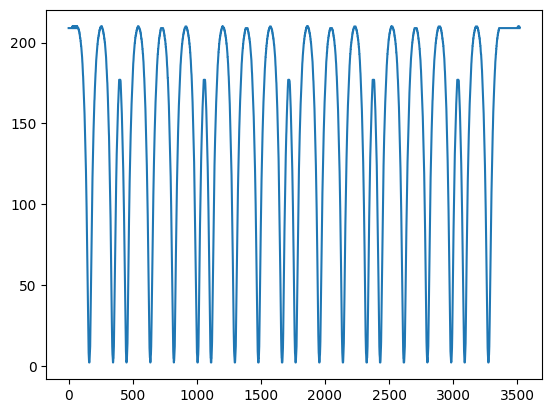

In [7]:
#Show lightness component (La*b*)
meanLAB=cv2.cvtColor(meanBGR, cv2.COLOR_BGR2LAB)
measured=meanLAB[:,:,0].flatten()

plt.plot(measured)

#the motor has moved 1800 steps back and forth at a constant speed
#and that the periodicity of the lightnes corresponds to a 180º movement

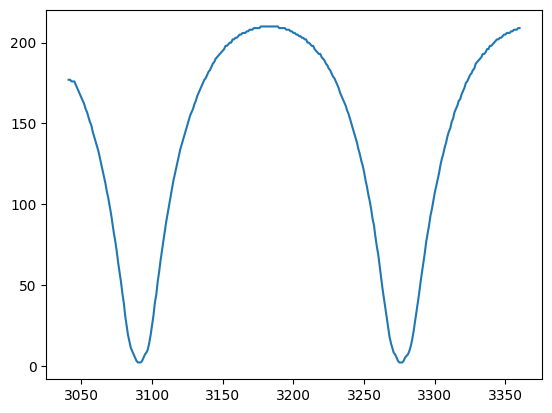

In [8]:
roi=[3040,3360]
plt.plot(np.linspace(1,len(measured[roi[0]:roi[1]]),len(measured[roi[0]:roi[1]]))+roi[0],measured[roi[0]:roi[1]])

In [9]:
#normalise measured
measured=measured-np.min(measured)
measured=measured/np.max(measured)

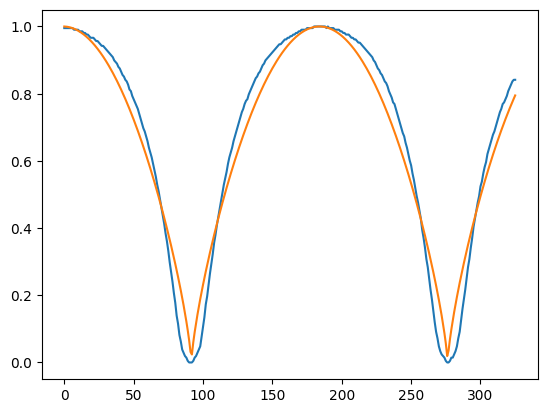

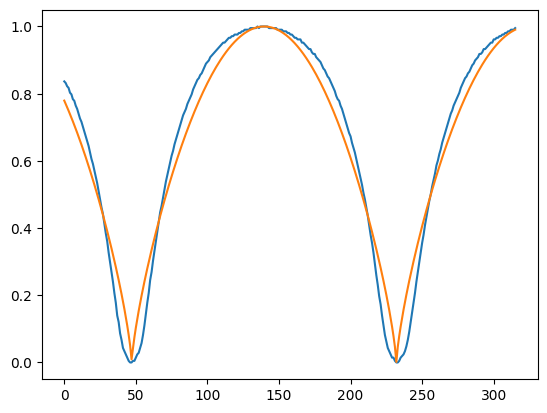

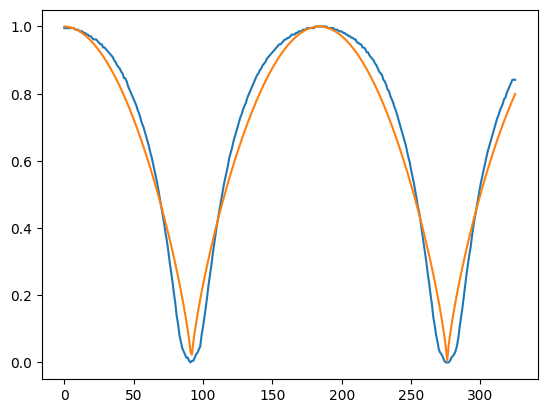

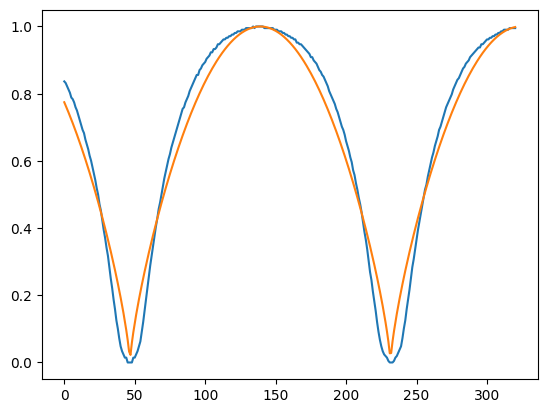

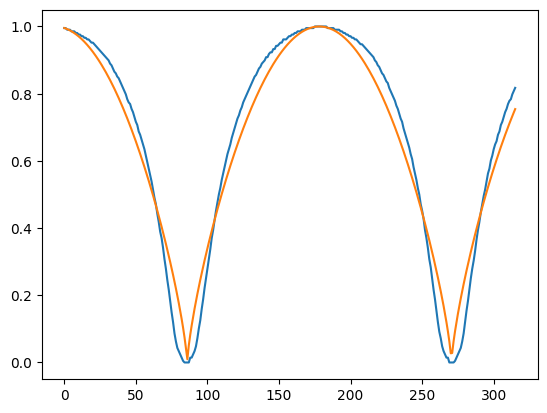

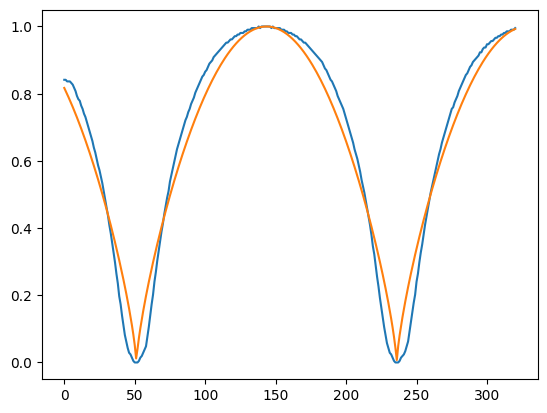

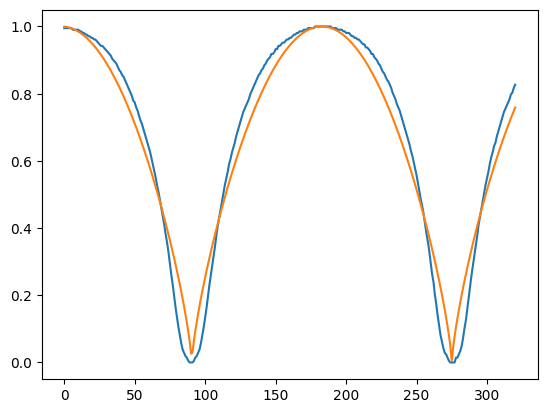

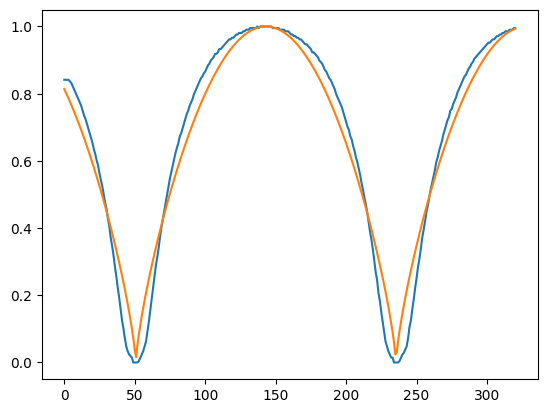

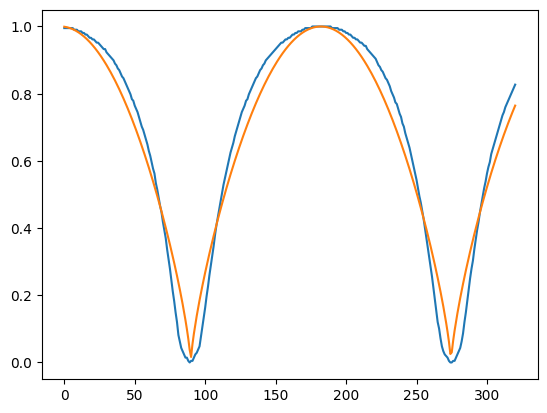

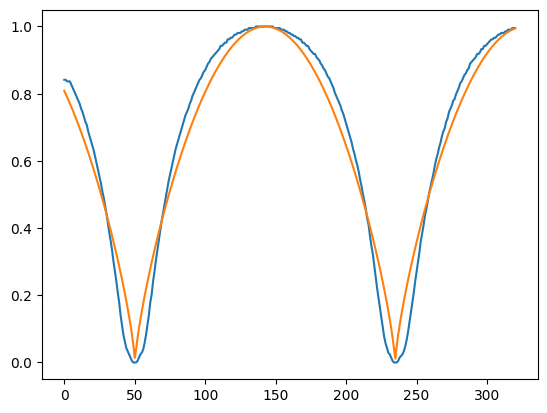

In [10]:
#Get same measurement using a numerical optimization analising the mean L graph
#start and end points are obtained manually
startPoints=[70,405,730,1065,1395,1720,2050,2380,2710,3040]
endPoints=[395,720,1055,1385,1710,2040,2370,2700,3030,3360]
numberOfSteps=1800

def sinPower(vector,w=0.3,phi=0):
    out=np.linspace(0,len(vector)-1,len(vector))
    out=np.sin(w*out+phi)+1
    out=out/2
    out=np.power(out,0.376)
    return out

def cost(x,measured):
    pred=sinPower(measured,x[0],x[1])
    return sum(np.power(measured-pred,2))

response=np.empty(0)
run=np.empty(0,dtype="int64")
ind=np.empty(0,dtype="int64")
l=np.zeros_like(startPoints,dtype='float')
w=np.zeros_like(startPoints,dtype='float')
phi=np.zeros_like(startPoints,dtype='float')
p=np.zeros_like(startPoints,dtype='float')
estimations=np.zeros_like(startPoints,dtype='float')

x0=[0.032,np.pi]
bou=[(0.031,0.035),(0,2*np.pi)]
for i in range(len(startPoints)):
    thisStart=startPoints[i]
    thisEnd=endPoints[i]
    thisMeasured=measured[thisStart:thisEnd+1]

    res=opt.minimize(
        cost,
        x0,
        args=(thisMeasured,),
        method='Nelder-Mead',
        tol=1e-6,
        bounds=bou
    )
    
    response=np.append(response,thisMeasured)
    run=np.append(run,np.ones_like(thisMeasured)*i)
    ind=np.append(ind,range(len(thisMeasured)))
    l[i]=len(thisMeasured)
    w[i]=res.x[0]
    phi[i]=res.x[1]
    estimations[i]=w[i]*90/np.pi*l[i]/numberOfSteps

    plt.plot(thisMeasured)
    plt.plot(sinPower(thisMeasured,res.x[0],res.x[1]))
    plt.show()

#even though we are not able to get a good approximation to the exact shape
#the calculation of the frequency is fantastic


In [11]:
#define the step equivalent, seq
seq=np.mean(estimations) #step equivalent
err=np.std(estimations) #standard error aproximation (overestimated)
seq=round(seq,ndigits=abs( math.floor(math.log10(abs(err))) ))

print("step equivalent (º/step):")
print(seq)
print("error estimation:")
print(err)

step equivalent (º/step):
0.174
error estimation:
0.001783030493923032


In [12]:
#optimal variables
optimal=pd.DataFrame({
    'run': range(0,len(startPoints)),
    'l': l,
    'w': w,
    'phi': phi
})

optimal

,run,l,w,phi
0,0,326.0,0.034016,1.596853
1,1,316.0,0.033987,3.111051
2,2,326.0,0.034087,1.589822
3,3,321.0,0.033987,3.127884
4,4,316.0,0.034035,1.789589
5,5,321.0,0.034009,2.972269
6,6,321.0,0.034041,1.632778
7,7,321.0,0.034028,2.984889
8,8,321.0,0.034020,1.659064
9,9,321.0,0.034027,3.004406


In [13]:
#organise the data from all the runs with corresponding optimal parameters
myData=pd.DataFrame({
    'run': run,
    'ind': ind,
    'response': response
})

#create the full data frame
myData=myData.merge(optimal,on='run',how='left')
#create phase column
myData['phase']=myData.apply(lambda row: row.phi+row.w*row.ind,axis=1)
#phase module 2pi
myData['phase']=myData.apply(lambda row: row.phase%(2*np.pi),axis=1)
#create angle column,
#keep in mind phase is not radians, 2pi is the periodicity, in this case 180º
myData['angle']=myData.apply(lambda row: row.phase/(2*np.pi)*180,axis=1)

myData

,run,ind,response,l,w,phi,phase,angle
0,0.0,0,0.995192,326.0,0.034016,1.596853,1.596853,45.746475
1,0.0,1,0.995192,326.0,0.034016,1.596853,1.630869,46.720963
2,0.0,2,0.995192,326.0,0.034016,1.596853,1.664885,47.695451
3,0.0,3,0.995192,326.0,0.034016,1.596853,1.698901,48.669939
4,0.0,4,0.995192,326.0,0.034016,1.596853,1.732917,49.644427
...,...,...,...,...,...,...,...,...
3205,9.0,316,0.990385,321.0,0.034027,3.004406,1.190651,34.109632
3206,9.0,317,0.990385,321.0,0.034027,3.004406,1.224678,35.084441
3207,9.0,318,0.995192,321.0,0.034027,3.004406,1.258705,36.059250
3208,9.0,319,0.995192,321.0,0.034027,3.004406,1.292733,37.034059


In [14]:
np.max(myData.angle)

np.float64(179.99130752348424)

In [15]:
len(myData)

3210

(array([36, 37]),)
(array([112]),)
91.20000000000002


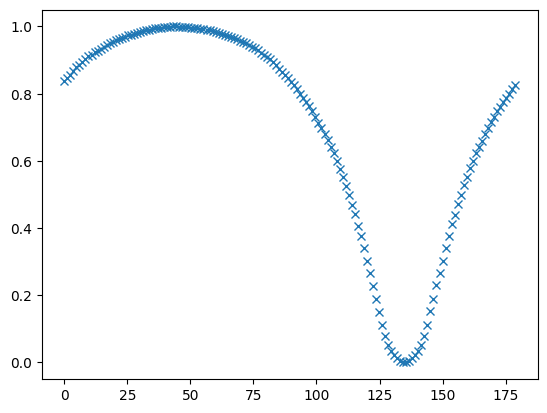

In [16]:
#average the runs to obtain the position equivalent of lightness
maxAngle=180
count=150
position=np.linspace(0,maxAngle,count,endpoint=False)
value=np.zeros_like(position)
halfWindow=0.8

for i in range(len(position)):
    pos=position[i]
    thisData=myData.copy()
    thisData['angle']=thisData.apply(lambda row: (row.angle-pos)%180,axis=1)
    thisData=thisData.loc[(thisData['angle']>180-halfWindow)|(thisData['angle']<halfWindow)]
    value[i]=thisData['response'].mean()

value=value-np.min(value)
value=value/np.max(value)

plt.plot(position,value,marker='x',linestyle='')

#next vectors should not have consecutive numbers, if not increase halfWindow
print(np.where(value==np.max(value)))
print(np.where(value==np.min(value)))
#next value should be exactly 90º, if not modify maxAngle and count
print(np.abs(position[np.where(value==np.min(value))[0][0]]-position[np.where(value==np.max(value))[0][0]]))

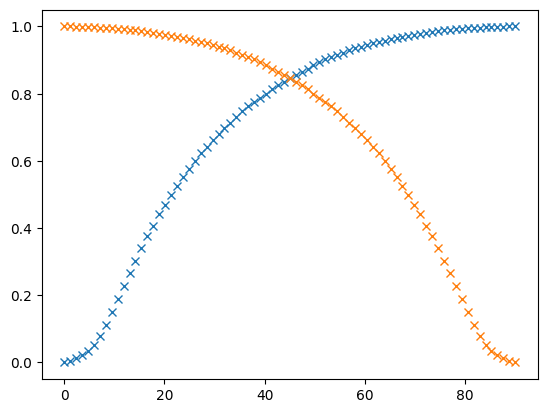

In [17]:
#show the result
origin=np.where(value==np.max(value))[0][0]
end=np.where(value==np.min(value))[0][0]

decre=np.linspace(0,90,end-origin+1)/90
cresc=np.linspace(90,0,end-origin+1)/90
final=value[origin:(end+1)]

plt.plot(cresc*90,final,marker='x',linestyle='')
plt.plot(decre*90,final,marker='x',linestyle='')


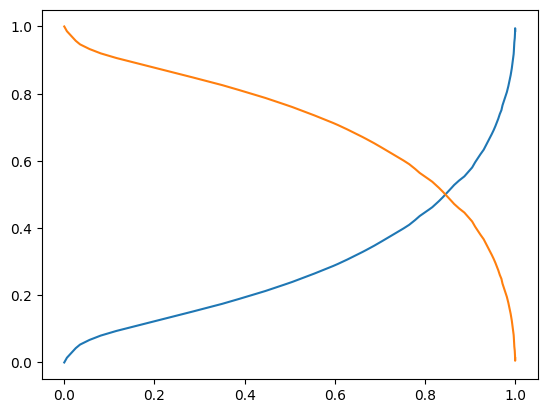

In [18]:
#interpolate to a continuous function, signal to position
signal2cresc=inter.interp1d(final,cresc,kind='linear')
signal2decre=inter.interp1d(final,decre,kind='linear')

x=np.linspace(0,1,10000)
y1=signal2cresc(x)
y2=signal2decre(x)
plt.plot(x,y1)
plt.plot(x,y2)


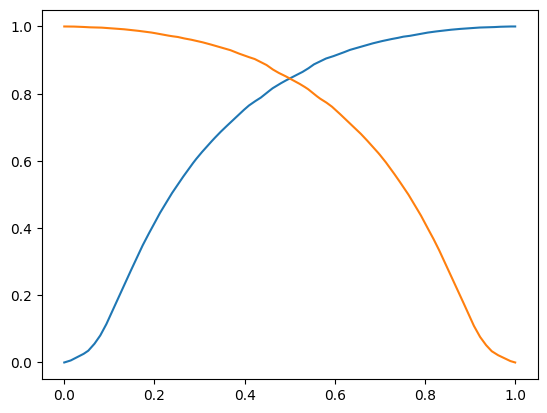

In [49]:
#interpolate to a continuous function, position to signal
cresc2signal=inter.interp1d(cresc,final,kind='linear')
decre2signal=inter.interp1d(decre,final,kind='linear')

x=np.linspace(0,1,10000)
y1=cresc2signal(x)
y2=decre2signal(x)
plt.plot(x,y1)
plt.plot(x,y2)

In [19]:
#*************************************************************
#Speed calibration
#*************************************************************

In [21]:
np.floor(90/seq)

np.float64(517.0)

In [22]:
#Load video and get average frame color (RGB)
vidcap = cv2.VideoCapture('./517_Speeds.MOV')
success,image = vidcap.read()
count = 0
meanBGR=np.zeros([1,1,3],dtype='uint8')
aux=np.zeros([1,1,3],dtype='uint8')
while success :
    for i in range(3):
        aux[0,0,i]=np.mean(image[:,:,i].flatten())
    meanBGR=np.append(meanBGR,aux,1)
    success,image = vidcap.read()
    if cv2.waitKey(10) == 27:                     # exit if Escape is hit
        break
    count += 1
meanBGR=meanBGR[:,1:count+1,:]

angular equivalent
0.174
number of steps for 90º
517.2413793103449


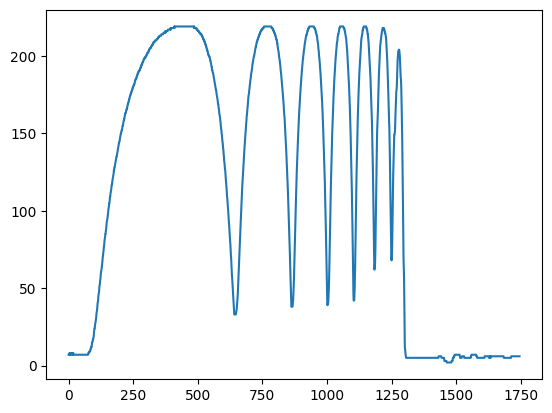

In [23]:
#Show lightness component (La*b*)
meanLAB=cv2.cvtColor(meanBGR, cv2.COLOR_BGR2LAB)
measured=meanLAB[:,:,0].flatten()

plt.plot(measured)

print("angular equivalent")
print(seq)
print("number of steps for 90º")
print(90/seq)

#the intention was to restrict themovement to 90º but there was a miscalculation of the number of steps
#anyway we can still use this data for a first fit of speed

In [26]:
measured=measured-np.min(measured)
measured=measured/np.max(measured)

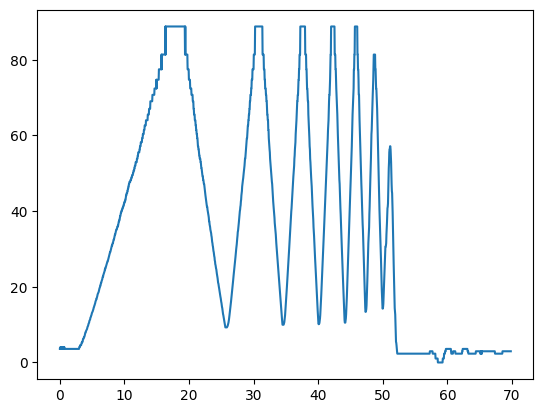

In [27]:
#translate to angular position (using crescent) and time (using fps)
fps=vidcap.get(cv2.CAP_PROP_FPS)
time=np.linspace(1,len(measured)-1,len(measured),dtype=int)/25
#normalise response first
pos=signal2cresc(measured)*90

plt.plot(time,pos)

#we can see quite nice straight lines in each of the movements, as expected from a constant speed


In [28]:
fps

25.0

In [30]:
np.where(np.round(pos-20)==0)

(array([ 154,  155,  156,  157,  158,  615,  616,  617,  668,  669,  850,
         879, 1013, 1097, 1112, 1254, 1294]),)

In [31]:
np.where(np.round(pos-60)==0)

(array([ 322,  323,  324,  325,  530,  531,  726,  913, 1076, 1131, 1206,
        1230]),)

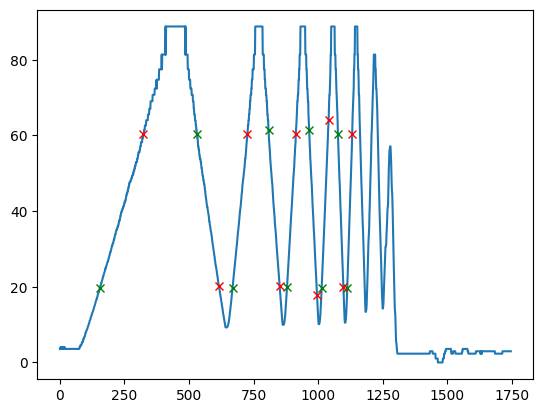

In [44]:
#separate manualy each range of constant speed input
startInd=[154,530,668,808,879,965,1013,1076,1112]
endInd=  [322,615,726,850,913,995,1040,1097,1131]

plt.plot(pos)
plt.plot(startInd,pos[startInd],marker='x',linestyle='',color="green")
plt.plot(endInd,pos[endInd],marker='x',linestyle='',color='red')


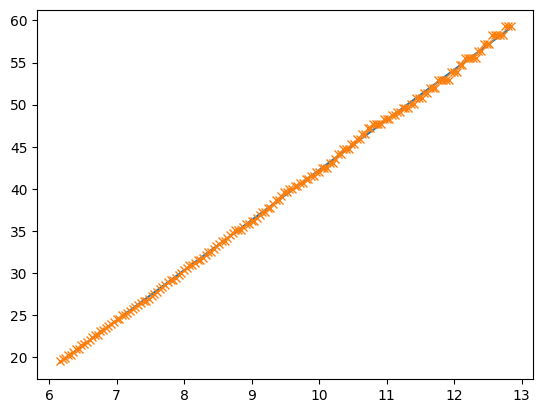

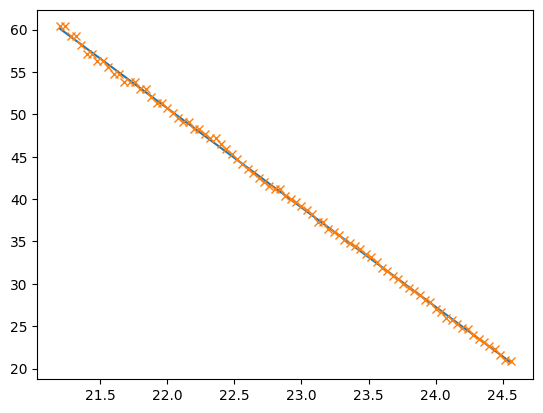

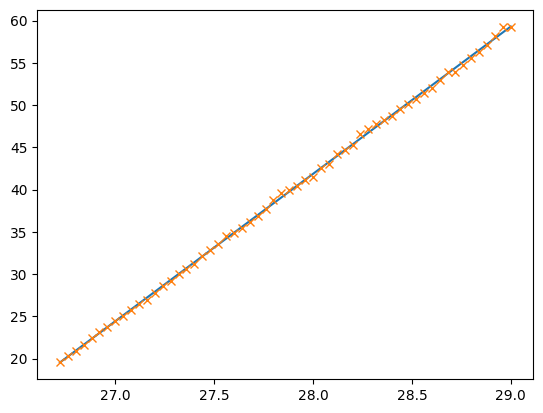

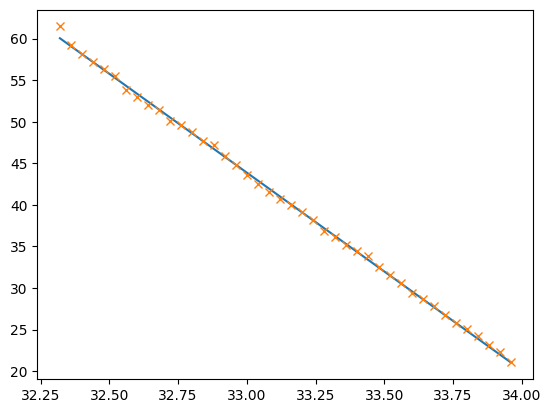

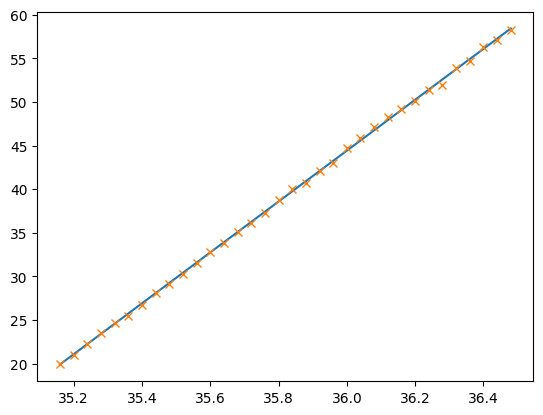

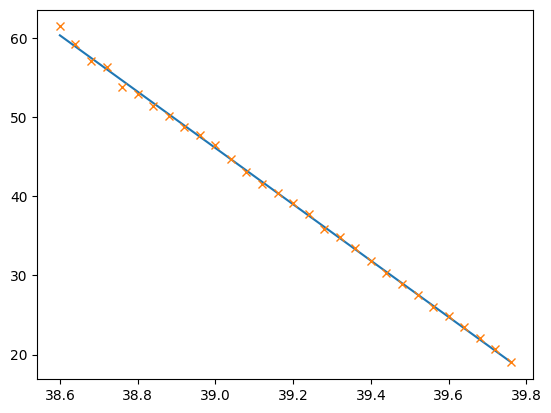

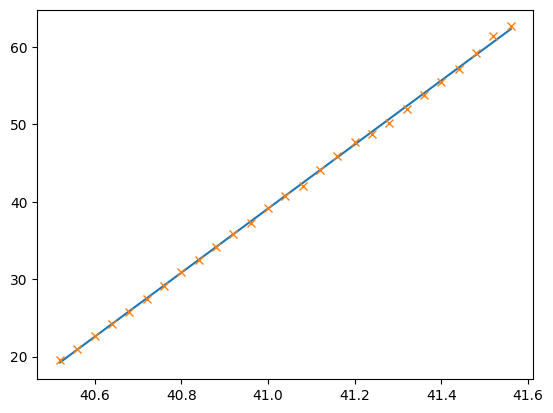

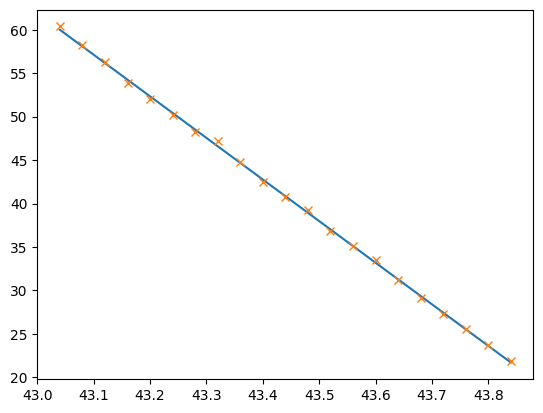

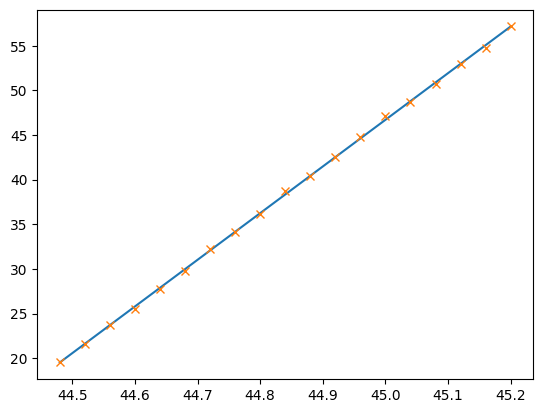

In [46]:
#fit a straight line for each speed input
inputs=np.array([1,-2,3,-4,5,-6,7,-8,9])
speeds=np.zeros_like(inputs,dtype="float64")

fits=[]
for i in range(len(startInd)):
    thisPos=pos[startInd[i]:endInd[i]]
    thisTime=time[startInd[i]:endInd[i]]
    fits.append(sts.linregress(thisTime,thisPos))
    speeds[i]=fits[i].slope

    plt.plot(thisTime, fits[i].intercept + fits[i].slope*thisTime)
    plt.plot(thisTime,thisPos,marker='x',linestyle='')
    plt.show()

#nice fits, there is some noise but we can't ask for much more

In [50]:
#define the input equivalent, ieq
def onlySlope(x,a):
    return x*a

out=opt.curve_fit(onlySlope,inputs,speeds)
ieq=out[0][0]
err=out[1][0][0] #variance of the fit
ieq=round(ieq,ndigits=abs(math.floor(math.log10(abs(err))))-1)

print("input equivalent (º/s/input):")
print(ieq)
print("error estimation:")
print(err)


input equivalent (º/s/input):
5.893
error estimation:
0.000597368498295569


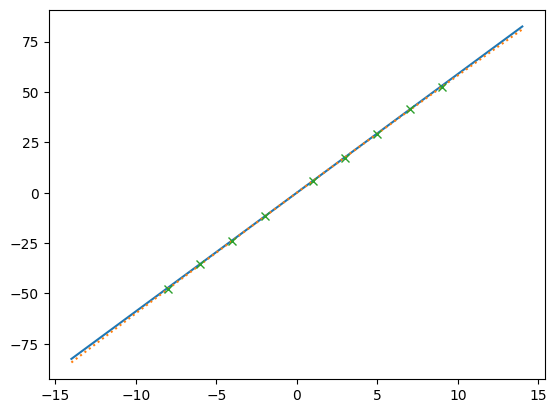

In [48]:
#compare to a parabolic function with no intercept
def order2NoInterc(x,a,b):
    return np.power(x,2)*a+b*x

out2=opt.curve_fit(order2NoInterc,inputs,speeds)

aux=np.linspace(-14,14,1000)
plt.plot(aux,onlySlope(aux,out[0][0]))
plt.plot(aux,order2NoInterc(aux,out2[0][0],out2[0][1]),linestyle=':')
plt.plot(inputs,speeds,marker='x',linestyle='')

#it shows a tiny decrease on speed for large (absolut) input with respect to the linear fit
#it can be a real effect, or due to accelerations, or due to the manual selection of points, no clear
#we go with the linear fit, it seems precise enough

In [ ]:
#*************************************************************
#Calibration File (.cal)
#*************************************************************

In [51]:
#save a calibration file
model='M1'
sourcePositionVideo='1800_BackAndForth.MOV'
sourceSpeedVideo='517_Speeds.MOV'
cFile=open('M1.cal','wb')
pickle.dump([ieq,seq,signal2cresc,signal2decre,cresc2signal,decre2signal,model,sourcePositionVideo,sourceSpeedVideo],cFile)
cFile.close()

del(ieq,seq,signal2cresc,signal2decre,cresc2signal,decre2signal,model,sourcePositionVideo,sourceSpeedVideo)


In [52]:
#test calibration file opening
cFile = open('M1.cal', 'rb')
[ieq,seq,signal2cresc,signal2decre,cresc2signal,decre2signal,model,sourcePositionVideo,sourceSpeedVideo] = pickle.load(cFile)
cFile.close()

ieq

np.float64(5.893)